In [1]:
!pip -q install roboflow
!pip -q install ultralytics
! pip -q install ruamel.yaml
! wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt

from roboflow import Roboflow
import sys
import ruamel.yaml
from ultralytics import YOLO
from pathlib import Path
import os
from collections import defaultdict
import copy
import math
import shutil
import numpy as np
import psutil
import gc
import matplotlib.pyplot as plt
import locale
from IPython.display import clear_output
import ctypes
import ctypes.util
import torch
import random


# deterministic set
torch.manual_seed(43)
random.seed(43)
np.random.seed(43)


rf = Roboflow(api_key="tD9RSesaXxGqmwVD6eVZ")
project = rf.workspace("hanyang-university-bd2kb").project("puddle-segmentation")
dataset = project.version(8).download("yolov8")


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.0.5 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.0 requires jupyterlab<5.0.0a0,>=4.0.6, but you have jupyterlab 4.0.5 which is incompatible.
pytoolconfig 1.2.6 requires packaging>=22.0, but you have packaging 21.3 which is incompatible.
tensorflowjs 4.13.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.
ydata-profiling 4.5.1 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.3 which is incompatible.
--2023-12-02 14:36:51--  https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8m-seg.pt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... conn

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3


loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.0.221, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to puddle-segmentation-8 in yolov8:: 100%|██████████| 4847/4847 [00:00<00:00, 8653.82it/s]


In [2]:
%cd /kaggle/working/puddle-segmentation-8

# trying to optimize RAM usage
gc.enable()

libc = ctypes.CDLL(ctypes.util.find_library('c'))
libc.malloc_trim(ctypes.c_int(0))

torch.set_num_threads(1)
os.environ["OMP_NUM_THREADS"] = "1"

/kaggle/working/puddle-segmentation-8


In [3]:
class YoloModel:
    def __init__(self, path_to_model: str, path_to_yaml: str,
                 train_perc: float, test_perc: float, val_perc: float,
                 ttvs_flag = 0, tp_flag = 0):
        """Инициализация переменных

        Args:
            path_to_model (str): путь до весов yolov8.pt
            path_to_yaml (str): путь до data.yaml файла датасета
            train_perc (float): доля тренировочных данных 
            test_perc (float): доля тестовых данных
            val_perc (float): доля валидационных данных
        """        
        self.path_to_model = path_to_model
        self.path_to_yaml = path_to_yaml
        self.train_path = Path('train') if os.path.exists(Path('train')) else None
        self.test_path = Path('test') if os.path.exists(Path('test')) else None
        self.val_path = Path('valid') if os.path.exists(Path('valid')) else None
        self.train_perc = train_perc
        self.test_perc = test_perc
        self.val_perc = val_perc
        
        self.ttvs_flag = ttvs_flag
        self.tp_flag = tp_flag
        
        self.ram_usage = []
        
        assert self.train_path != None, 'Директория train отсутствует'
        if (self.val_path == None):
            os.mkdir("valid", mode=0o777)
            os.mkdir("valid/images", mode=0o777)
            os.mkdir("valid/labels", mode=0o777)
            self.val_path = Path("valid")
        if (self.test_path == None):
            os.mkdir("test", mode=0o777)
            os.mkdir("test/images", mode=0o777)
            os.mkdir("test/labels", mode=0o777)
            self.test_path = Path("test")
    
    def get_ram_usage(self,):
        """Gets the current RAM usage of the system.

        Returns:
            float: RAM usage in GB.
        """
        return psutil.virtual_memory().used / 1e9

    def train(self, folder_name: str, iters: int) -> YOLO: 
        """Инициализация модели и обучение

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        # yaml.preserve_quotes = True
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = './'+folder_name+'/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        self.ram_usage.append(self.get_ram_usage())
        model = YOLO(self.path_to_model)
        model.train(
            # Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def retrain(self, folder_name: str, iters: int,) -> YOLO:
        """Обучение модели на всех предыдущих частях данных для профилакти просадки метрики

        Args:
            folder_name (str): название директории с частью данных
            iters (int): кол-во интераций

        Returns:
            YOLO: экземпляр обученной модели
        """        
        os.mkdir("retrain", mode=0o777)
        os.mkdir("retrain/train", mode=0o777)
        os.mkdir("retrain/train/images", mode=0o777)
        os.mkdir("retrain/train/labels", mode=0o777)

        # собираем список всех кусков данных до нашего folder_name
        folder_num = np.arange(1, int(folder_name.split('_')[-1]) + 1)
        cls = folder_name.split("_")[1]
        source_pathes = [f"temp_{cls}_{i}" for i in folder_num]

        # копируем все собранные куски данных в папку retrain
        for path in source_pathes:
            # собираем все файлы
            all_images_train = os.listdir(path+"/train/images")
            all_labels_train = os.listdir(path+"/train/labels")

            for image in all_images_train:
                shutil.copyfile(path+"/train/images/" + image,
                                "retrain/train/images/" + image)
            for label in all_labels_train:
                shutil.copyfile(path+"/train/labels/" + label,
                                "retrain/train/labels/" + label)

        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
        
        self.ram_usage.append(self.get_ram_usage())
        # load a pretrained model (recommended for training)
        model = YOLO(self.path_to_model)
        model.train(# Random Seed parameters
            deterministic=True,
            seed=43,
            data=self.path_to_yaml, 
            pretrained=True,
            exist_ok=True,
            epochs=iters,
            optimizer="SGD",
            device=0,)
        
        return model
    
    def test(self, folder_name: str, model: YOLO):
        """Тестирование модели

        Args:
            model (YOLO): экземпляр обученной модели

        Returns:
            _type_: _description_
        """        
        # Корректируем data.yaml файл
        yaml = ruamel.yaml.YAML()
        with open('data.yaml', 'r+') as fp:
            data = yaml.load(fp)
            for elem in data:
                if elem == 'train':
                    data[elem] = 'retrain/train/images'
                elif elem == 'val':
                    data[elem] = f"./valid_{folder_name.split('_')[1]}/images"
                elif elem == 'test':
                    data[elem] = f"./test_{folder_name.split('_')[1]}/images"
            fp.truncate(0)
            fp.seek(0)
            yaml.dump(data, fp)
            
        metrics = model.val(data=self.path_to_yaml, split="test")
        return metrics
    
    def train_test_val_split(self, keep_perc: float):
        """Разделение изначального датасета на заданные доли train/test/val. Удаление 1-keep_perc доли данных 

        Args:
            keep_perc (float): доля данных, которую нужно оставить
        """        
        # создаем директории для объединения всех файлов
        os.mkdir("temp", mode=0o777)
        os.mkdir("temp/images", mode=0o777)
        os.mkdir("temp/labels", mode=0o777)
            
        source_pathes = (self.train_path / 'images', self.train_path / 'labels',\
                        self.test_path / 'images', self.test_path / 'labels',\
                        self.val_path / 'images', self.val_path / 'labels',)
        destination = Path('temp')

        for path in source_pathes:
            # собираем все файлы
            allfiles = os.listdir(path)
            # итерируем по всем файлам, чтобы переместить их в папку назначения
            sub_folder = path.name # images or labels
            for f in allfiles:
                src_path = os.path.join(path, f)
                dst_path = os.path.join(destination / sub_folder, f)
                os.rename(src_path, dst_path)
        total_num = len(allfiles)
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("temp/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
        print(f"Кол-во пустых файлов - {empty_count}")
        # Оставляем указанный процент данных
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(pathes)
            num_to_del = num_files*(1-keep_perc)
            for i, file_path in enumerate(pathes.copy()):
                if i+1 >= num_to_del:
                    break
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                try:
                    Path("temp",'images',".".join(f)).unlink()
                    file_path.unlink()
                except OSError as e:
                    # Файл не найден (скорее всего имеет несколько классов и был уже перемещен)
                    pass
                classes[cls].remove(file_path)
        for cls in classes.keys():
            os.mkdir(f"valid_{cls}", mode=0o777)
            os.mkdir(f"test_{cls}", mode=0o777)


            os.mkdir(f"valid_{cls}/labels", mode=0o777)
            os.mkdir(f"valid_{cls}/images", mode=0o777)
            os.mkdir(f"test_{cls}/labels", mode=0o777)
            os.mkdir(f"test_{cls}/images", mode=0o777)
        # Распределяем данные по директориям train, test, val с учетом указанных пропорций
        class_copy = copy.deepcopy(classes)
        for cls, pathes in zip(list(classes.keys()), list(classes.values())):
            num_files = len(class_copy[cls])
            num_to_mv_train = int(num_files * self.train_perc)
            num_to_mv_test = int(num_files * self.test_perc)
            num_to_mv_val = int(num_files * self.val_perc)
            # print(num_files, num_to_mv, len(pathes))
            temp_dict_name = "train"
            for i, file_path in enumerate(pathes.copy()):
                if i+1 > num_to_mv_train and i+1 < num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"valid_{cls}"
                elif i+1 > num_to_mv_val + num_to_mv_train:
                    temp_dict_name = f"test_{cls}"
                f = file_path.name.split('.')[:-1]
                f.append('jpg')
                shutil.copyfile(Path("temp", "images", ".".join(f)),
                                Path(temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                shutil.copyfile(file_path,
                                Path(temp_dict_name, "labels").joinpath(file_path.name))
                if temp_dict_name != "train":
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                classes[cls].remove(file_path)
            dir_path = f"valid_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
            dir_path = f"test_{cls}/images"
            print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
        dir_path = f"train/labels"
        print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        
        shutil.rmtree("temp")
    
    def __train_set_of(self,n):
        x = []
        temp = 2
        while temp < n:
            x.append(temp)
            if temp < 10:
                temp+=2
            elif temp >= 10 and temp < 30:
                temp += 3
            elif temp >= 30 and temp < 100:
                temp += 5
            elif temp >= 100 and temp < 200:
                temp += 10
            elif temp >= 200 and temp < 300:
                temp += 50
            elif temp >= 300 and temp < 500:
                temp +=100
            elif temp >= 500:
                temp += 500
        if x[-1] != n:
            x.append(n)
            
        return x


    def take_piece(self, piece_perc: float = None, fib_flag:bool = False) -> (dict, dict):
        """Разделение исходного датасета на части равные доле piece_perc по директориям temp_{n}, n = {1..1/piece_perc}

        Args:
            piece_perc (float): доля части данных, на которые нужно поделить датасет
        """

        source_pathes = (self.train_path / 'images', self.train_path / 'labels')
        
        # Создаем словарь, где ключ - метка класса, значение - множество путей к label файлам данного класса
        classes = defaultdict(set)
        empty_count = 0
        for txt_path in Path("train/labels").glob("*.txt"):
            with txt_path.open() as f:
                text = f.read()
                # Каждому объекту на изображении соотвествует одна строка, где первое значение - метка класса,
                # а остальное - координаты сегментации
                for obj in text.split('\n'):
                    if len(obj) > 0:
                        classes[obj.split()[0]].add(txt_path)
                    else:
                        print(f"Пустой файл: {txt_path}")
                        empty_count += 1
                        
        print(f"Кол-во пустых файлов - {empty_count}")
        d_c = {key: len(value) for key, value in zip(classes.keys(), classes.values())}
        print(*[f"Класс {key} содержит {value} объекта(-ов)\n" for key, value in zip(d_c.keys(), d_c.values())])
        
        cls_tl_dict = defaultdict(list) # key - class, value - result of __train_set_of(n)
        cls_fif_dict = defaultdict(int) # key - class, value - num folders
        # Разделить сначала по классам, а потом внутри класса разделить по __train_set_of
        for cls in classes.keys():
            print(f"Класс {cls}")
            total_num = len(classes[cls])
            print(f"\tКол-во train класса {cls}: {total_num}")
            if fib_flag == True:
                n = total_num
                train_list = self.__train_set_of(n)
                files_in_folder = []
                for i in range(len(train_list)):
                    if i == 0:
                        files_in_folder.append(train_list[i])
                        continue
                    files_in_folder.append(train_list[i] - train_list[i-1])
                print(f"\tКоличество данных (train) на каждой итерации класса {cls}: {train_list}")
                cls_tl_dict[cls] = train_list
                cls_fif_dict[cls] = len(files_in_folder)

            if fib_flag == True:
                self.num_folders = len(files_in_folder)
                print(f"\tКол-во директорий для класса {cls}: {self.num_folders} ")
            else:
                self.num_folders = 1 / piece_perc
            for folder in range(int(self.num_folders)):
                os.mkdir(f"temp_{cls}_{folder+1}", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train", mode=0o777)

                os.mkdir(f"temp_{cls}_{folder+1}/train/labels", mode=0o777)
                os.mkdir(f"temp_{cls}_{folder+1}/train/images", mode=0o777)
            
            # Распределяем данные по директориям  
            class_copy = copy.deepcopy(classes)
            for f_i, folder in enumerate(range(int(self.num_folders))):
                folder_name = f"temp_{cls}_{folder+1}"
                num_to_mv_train = int(num_files * piece_perc) if fib_flag == False else files_in_folder[f_i]
                print(f"\tnum_to_mv_train {num_to_mv_train}, folder {folder}, cls {cls}")
                # print(num_files, num_to_mv, len(pathes))
                temp_dict_name = "train"
                for i, file_path in enumerate(classes[cls].copy()):
                    if i+1 > num_to_mv_train:
                        break
                    f = file_path.name.split('.')[:-1]
                    f.append('jpg')
                    shutil.copyfile(Path("train", "images", ".".join(f)),
                                    Path(folder_name, temp_dict_name, "images").joinpath(Path("train", "images", ".".join(f)).name))
                    shutil.copyfile(file_path,
                                    Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))
                    # remove another classes in label file
                    orig_lines = [line.strip() for line in open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name))]
                    new_lines = [l for l in orig_lines if l.split()[0] == str(cls)]

                    with open(Path(folder_name, temp_dict_name, "labels").joinpath(file_path.name), 'w') as fp:
                        print(*new_lines, sep='\n', file=fp)
                    classes[cls].remove(file_path)
            for folder in range(int(self.num_folders)):
                dir_path = f"temp_{cls}_{folder+1}/train/labels"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
                dir_path = f"temp_{cls}_{folder+1}/train/images"
                print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), "\n")
        return cls_tl_dict, cls_fif_dict
    
    def plot_result(self, result_dict: dict, color_dict = "green", fib_list:list = None):
        '''Функция для отрисовки графиков зависимости метрик от размера обучающей выборки

        Args:
            result_dict (dict): словарь с метриками {доля данных: массив метрик}
            color_dict (dict): словарь с индикаторами повторного обучения
        '''
        metrics_names = ("mAP","mAP50", "mAP75")
        colors = list(color_dict.values()) if color_dict != 'green' else color_dict
        if fib_list == None:
            for i, metric in enumerate(metrics_names):
                plt.scatter(list(result_dict.keys()), [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(list(result_dict.keys()), [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(result_dict.keys())) 
                plt.show()
        else:
            for i, metric in enumerate(metrics_names):
                plt.scatter(fib_list, [j[i] for j in result_dict.values()], color=colors, zorder=1)
                plt.plot(fib_list, [j[i] for j in result_dict.values()], linestyle='-')
                plt.ylabel(metric)
                plt.xlabel("Num files (train)")
                plt.xticks(ticks=list(fib_list)) 
                plt.show()

    def plot_ram_usage(self,):
        '''Функция для отрисовки использования RAM в процессе обучения'''
        plt.plot(self.ram_usage, marker='o', linestyle='-', color='b')
        plt.xlabel('Iteration')
        plt.ylabel('RAM Usage (GB)')
        plt.title('RAM Usage During Training')
        plt.show()
    
    def __early_stopping(self, result_dict: dict, prev_num: int, threshold: float) -> bool:
        keys_sorted = sorted(result_dict.keys())
        prev_results = np.array([result_dict[i][0] for i in keys_sorted[-prev_num-1:-1]])
        res = result_dict[keys_sorted[-1]][0] - prev_results
        print(f"Progress for {prev_num} last iterations with {threshold} threshold = {np.sum(res)}")
        if np.sum(res) < threshold:
            return True
        else:
            return False
    
    def increm_learning(self, keep_perc: float, iters: int, piece_perc:float = None, fib_flag:bool = None, prev_num:int = 3, threshold:float = 0.01) -> (list,list):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            cls_tl_dict, cls_fif_dict = self.take_piece(piece_perc, fib_flag)
            self.tp = 1
        else:
            assert fib_flag == False
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        # Инкрементальное обучение 
        for cls in cls_tl_dict.keys():
            result_dict = defaultdict(list)
            # словарь с индикаторами повторного обучения
            color_dict = defaultdict(str)
            # переменная для отслеживания максимального map в целях профилактики просадок метрики
            max_map = 0
            self.path_to_model = native_path_to_model
            for folder in range(cls_fif_dict[cls]):
                if (folder > prev_num):
                    if self.__early_stopping(result_dict, prev_num, threshold):
                        break
                libc = ctypes.CDLL(ctypes.util.find_library('c'))
                libc.malloc_trim(ctypes.c_int(0))

                torch.set_num_threads(1)
                folder_name = f"temp_{cls}_{folder+1}"
                # дообучаем модель
                model = self.train(folder_name, iters)
                # тестируем модель
                metrics = self.test(folder_name, model)
                # проверяем, что метрика улучшается
                if metrics.seg.map > max_map:
                    max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "green"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                else:
                    self.path_to_model = native_path_to_model
                    # дообучаем модель
                    model = self.retrain(folder_name, iters)
                    # тестируем модель
                    metrics = self.test(folder_name, model)
                    if metrics.seg.map > max_map:
                        max_map = metrics.seg.map
                    # заносим метрики в словарь
                    result_dict[folder].append(metrics.seg.map)
                    result_dict[folder].append(metrics.seg.map50)
                    result_dict[folder].append(metrics.seg.map75)
                    color_dict[folder] = "blue"
#                     clear_output(wait=True)
                    del(model)
                    del(metrics)
                    gc.collect()
                    self.path_to_model = "./runs/segment/train/weights/last.pt"
                    shutil.rmtree("retrain")
                
            print(f"Итоговый результат (инкрементальное обучение) для класса {cls}: \n {result_dict}")
            print(f"Количество данных (train) для класса {cls}: {cls_tl_dict[cls]}")
            self.plot_result(result_dict, color_dict) if fib_flag == False else self.plot_result(result_dict, color_dict, cls_tl_dict[cls][:len(result_dict.keys())])

    def base_learning(self, keep_perc: float, piece_perc: float, iters: int):
        os.environ['WANDB_DISABLED'] = 'true'
        # делим датасет на тренировочную/тестовую/валидационную выборку
        if self.ttvs_flag == 0:
            self.train_test_val_split(keep_perc)
            self.ttvs = 1
        if self.tp_flag == 0:
            self.take_piece(piece_perc)
            self.tp_flag = 1
        else: 
            self.num_folders = 1 / piece_perc
        # путь к изначальным весам yolov8 для повторного обучения при понижении метрики
        native_path_to_model = self.path_to_model
        # словарь с метриками {доля данных: массив метрик}
        result_dict = {k_p:[] for k_p in range(int(self.num_folders))}
        
        for folder in range(int(self.num_folders)):
            folder_name = f"temp_{folder+1}"
            # дообучаем модель
            model = self.retrain(folder_name, iters)
            # тестируем модель
            metrics = self.test(model)
            # заносим метрики в словарь
            result_dict[folder].append(metrics.seg.map)
            result_dict[folder].append(metrics.seg.map50)
            result_dict[folder].append(metrics.seg.map75)
            clear_output(wait=True)
            del(model)
            del(metrics)
            gc.collect()
            shutil.rmtree("retrain")
            
        print(f"Итоговый результат (базовое обучение): \n {result_dict}")
        self.plot_result(result_dict)
        
        return result_dict

Пустой файл: temp/labels/image1262_jpeg_jpg.rf.f6a8e4b4c0eb096527a742a41303d802.txt
Пустой файл: temp/labels/image88_jpeg_jpg.rf.253074927d14756c8d4973890e49988d.txt
Пустой файл: temp/labels/image1712_jpeg_jpg.rf.6743aa15f86650f685950f10335cf521.txt
Пустой файл: temp/labels/KakaoTalk_20230303_155124767_05_jpg.rf.462d7aa0eea136c4312720cdd11ca6ce.txt
Пустой файл: temp/labels/image1804_jpeg_jpg.rf.d5363ee6e9d102616061d5e9cd21c9b3.txt
Пустой файл: temp/labels/image19_jpeg_jpg.rf.5b1c01c0e5778c81a7002d3c74a700ab.txt
Пустой файл: temp/labels/image1712_jpeg_jpg.rf.cd253201a1e39224af7ac10a51f12418.txt
Пустой файл: temp/labels/KakaoTalk_20230112_175920520_mp4-1_jpg.rf.04d9f2e8993ecb9e8302e106c7aa5294.txt
Пустой файл: temp/labels/image338_jpeg_jpg.rf.07290b77d8614388be0b6c5b477f26a0.txt
Пустой файл: temp/labels/image1262_jpeg_jpg.rf.96c564b12ee68002c5df0c945a013755.txt
Пустой файл: temp/labels/image19_jpeg_jpg.rf.24a170542d199cfbc933b873efd7927c.txt
Пустой файл: temp/labels/image792_jpeg_jpg.rf.

100%|██████████| 755k/755k [00:00<00:00, 14.9MB/s]
2023-12-02 14:37:05,880	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-12-02 14:37:07,079	INFO util.py:129 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


100%|██████████| 6.23M/6.23M [00:00<00:00, 76.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_1/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 187.04it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<00:00, 996.98it/s] 

val: New cache created: /kaggle/working/puddle-segmentation-8/valid_0/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       1.6G      1.052      5.814      3.335      1.225          5        640: 100%|██████████| 1/1 [00:03<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        409     0.0779      0.127     0.0234    0.00835     0.0565     0.0905     0.0149     0.0045



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G       1.38      5.206      4.613      1.282          3        640: 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        409     0.0695      0.117     0.0234    0.00806     0.0547      0.088     0.0137     0.0043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       1.6G      1.051      1.671      4.106      1.959          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.50it/s]

                   all        240        409     0.0691      0.124     0.0222    0.00785     0.0549     0.0831     0.0136    0.00423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.58G      1.271       7.64        5.3      2.102          2        640: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.52it/s]

                   all        240        409     0.0674       0.12     0.0215    0.00773     0.0482     0.0733     0.0136    0.00408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       1.6G      1.166      3.839      4.393      1.419          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.51it/s]

                   all        240        409     0.0674      0.125     0.0215    0.00754     0.0534     0.0859     0.0133     0.0039



5 epochs completed in 0.011 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]


                   all        240        409     0.0787      0.127     0.0236     0.0083     0.0584     0.0905     0.0149    0.00449
Speed: 1.1ms preprocess, 12.6ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▇▄▁█
wandb:        metrics/mAP50(M) █▂▁▁█
wandb:     metrics/mAP50-95(B) █▅▂▁▇
wandb:     metrics/mAP50-95(M) █▅▄▁█
wandb:    metrics/precision(B) ▇▂▂▁█
wandb:    metrics/precision(M) ▇▅▆▁█
wandb:       metrics/recall(B) █▁▆▃█
wandb:       metrics/recall(M) █▇▅▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▁▆▃
wandb:          train/cls_loss ▁▆▄█▅
wandb:          train/dfl_loss ▁▁▇█▃
wandb:          train/seg_loss ▆▅▁█▄
wandb:            val/box_loss ▆▇▅▁█
wandb:            val/cls_loss ▁▄▆▇█
wandb:            val/dfl_loss ▁▃▅▅█
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<00:00, 985.14it/s]

val: New cache created: /kaggle/working/puddle-segmentation-8/test_0/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.38it/s]


                   all        241        381     0.0511     0.0997     0.0212    0.00751     0.0558     0.0814     0.0157    0.00441
Speed: 1.4ms preprocess, 27.8ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_2/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 693.73it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.74G      1.781      4.919      4.055      1.842         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        409     0.0382     0.0954     0.0158    0.00506     0.0265     0.0685     0.0067     0.0021



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.61G      1.494      5.345      3.519      1.499          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.44it/s]

                   all        240        409      0.038     0.0978     0.0157    0.00514     0.0241     0.0604    0.00661    0.00217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.61G      1.556      6.897      3.317      1.974          7        640: 100%|██████████| 1/1 [00:00<00:00,  5.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        409     0.0334     0.0978     0.0157    0.00516     0.0237     0.0587    0.00653    0.00212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.63G      1.863      7.377      3.582      1.967          9        640: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.47it/s]

                   all        240        409     0.0376        0.1     0.0157    0.00522     0.0255     0.0636    0.00688    0.00218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.61G      2.256      5.807      4.272      2.376          6        640: 100%|██████████| 1/1 [00:00<00:00,  5.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        409     0.0365      0.103     0.0156    0.00526     0.0259     0.0611    0.00671    0.00216



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        409     0.0365        0.1     0.0155    0.00521     0.0278     0.0636    0.00709     0.0022
Speed: 1.5ms preprocess, 13.6ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▆▄▄▁
wandb:        metrics/mAP50(M) ▃▂▁▅█
wandb:     metrics/mAP50-95(B) ▁▄▅██
wandb:     metrics/mAP50-95(M) ▁▆▂▇█
wandb:    metrics/precision(B) ██▁▇▅
wandb:    metrics/precision(M) ▆▂▁▄█
wandb:       metrics/recall(B) ▁▅▅██
wandb:       metrics/recall(M) █▂▁▄▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▂▄█
wandb:          train/cls_loss ▆▂▁▃█
wandb:          train/dfl_loss ▄▁▅▅█
wandb:          train/seg_loss ▁▂▇█▄
wandb:            val/box_loss █▆▅▃▁
wandb:            val/cls_loss █▃▁▂▄
wandb:            val/dfl_loss ▆▇█▄▁
wandb:            val/seg_loss ▂▁▆▂█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


                   all        241        381     0.0661      0.063     0.0203    0.00713     0.0441      0.042    0.00942    0.00294
Speed: 1.4ms preprocess, 30.6ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 4 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4/4 [00:00<00:00, 1398.68it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.66G      1.951       5.36      3.643      1.918         16        640: 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409      0.075      0.127     0.0234    0.00822     0.0561     0.0831     0.0147    0.00432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.98G      2.012      4.851      3.924      1.778         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

                   all        240        409     0.0732      0.122     0.0221    0.00814     0.0581     0.0929     0.0142    0.00427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.88G      1.362      4.173      4.222      1.441         13        640: 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409      0.071       0.13     0.0225    0.00804     0.0553     0.0929     0.0139    0.00425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.87G      1.838      5.046       4.17      1.856         14        640: 100%|██████████| 1/1 [00:00<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0736       0.13     0.0226    0.00782     0.0529      0.088     0.0133    0.00399



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       2.9G      1.372      4.273      4.035      1.487         17        640: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0716      0.125     0.0224    0.00768     0.0507     0.0831     0.0132    0.00385



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        409     0.0749      0.127     0.0234    0.00819     0.0562     0.0831     0.0146    0.00429
Speed: 1.3ms preprocess, 14.4ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▁▃▄█
wandb:        metrics/mAP50(M) █▅▄▁█
wandb:     metrics/mAP50-95(B) █▇▅▁▇
wandb:     metrics/mAP50-95(M) █▇▇▁▇
wandb:    metrics/precision(B) █▅▁▆█
wandb:    metrics/precision(M) ▅█▄▁▆
wandb:       metrics/recall(B) ▆▁██▆
wandb:       metrics/recall(M) ▁██▅▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇█▁▆▁
wandb:          train/cls_loss ▁▄█▇▆
wandb:          train/dfl_loss █▆▁▇▂
wandb:          train/seg_loss █▅▁▆▂
wandb:            val/box_loss ▁▅▄▅█
wandb:            val/cls_loss ▁▃▅▇█
wandb:            val/dfl_loss ▁▄▅██
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0531     0.0971     0.0211    0.00744     0.0589      0.084      0.016    0.00448
Speed: 1.1ms preprocess, 30.6ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_3/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 473.99it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_3/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.99G      2.224      3.885      3.628      2.071         25        640: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0294     0.0954     0.0152    0.00486     0.0262     0.0587    0.00634    0.00225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.61G      2.493      5.891      3.417      2.116          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0313     0.0978     0.0152    0.00493     0.0265     0.0636    0.00648    0.00205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.61G      2.781      5.429      3.648      2.803          8        640: 100%|██████████| 1/1 [00:00<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0323     0.0856     0.0159    0.00518     0.0272     0.0587    0.00642    0.00212



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.72G       2.43      4.966      3.385      2.209         19        640: 100%|██████████| 1/1 [00:00<00:00,  5.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0334     0.0905     0.0162    0.00528     0.0278     0.0562    0.00672    0.00223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.63G      1.831      4.493      3.477      1.903         10        640: 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0354        0.1      0.016    0.00528     0.0261     0.0538     0.0068    0.00221



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        409     0.0337     0.0905     0.0162    0.00525     0.0296     0.0611    0.00673    0.00221
Speed: 1.5ms preprocess, 14.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▁▆█▇
wandb:        metrics/mAP50(M) ▁▃▂██
wandb:     metrics/mAP50-95(B) ▁▂▆██
wandb:     metrics/mAP50-95(M) █▁▃▇▇
wandb:    metrics/precision(B) ▁▄▆██
wandb:    metrics/precision(M) ▁▂▃▄█
wandb:       metrics/recall(B) ▇█▁▄▄
wandb:       metrics/recall(M) ▃█▃▁▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▆█▅▁
wandb:          train/cls_loss ▇▂█▁▃
wandb:          train/dfl_loss ▂▃█▃▁
wandb:          train/seg_loss ▁█▆▅▃
wandb:            val/box_loss █▇▄▁▁
wandb:            val/cls_loss █▇▅▃▁
wandb:            val/dfl_loss ▁▅▆▇█
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381      0.062      0.102     0.0211    0.00702     0.0489     0.0472    0.00913    0.00295
Speed: 1.3ms preprocess, 30.5ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 6 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6/6 [00:00<00:00, 853.54it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G      1.141       4.67      3.247      1.423         17        640: 100%|██████████| 1/1 [00:01<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0758       0.13     0.0234    0.00832     0.0554     0.0831     0.0149    0.00447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.98G      1.818      4.944      3.653      1.864         22        640: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.33it/s]

                   all        240        409     0.0778      0.127     0.0231    0.00833     0.0551     0.0856     0.0148    0.00444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.86G      1.568      5.548      3.691      1.685         22        640: 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]

                   all        240        409     0.0732      0.132      0.023    0.00818     0.0531      0.088     0.0141    0.00442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.91G      2.054      4.437      3.671      2.057         29        640: 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0712      0.122     0.0229    0.00791     0.0517     0.0856     0.0135    0.00415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.89G      1.457      3.398      3.724      1.692         25        640: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0707      0.117     0.0221    0.00769     0.0489     0.0782     0.0134    0.00411



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        409      0.076       0.13     0.0233    0.00825     0.0548     0.0823     0.0149    0.00443
Speed: 1.2ms preprocess, 14.2ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▄▂▁▆
wandb:        metrics/mAP50(M) █▇▄▁█
wandb:     metrics/mAP50-95(B) ██▆▁▇
wandb:     metrics/mAP50-95(M) █▇▇▁▇
wandb:    metrics/precision(B) ▆█▃▁▆
wandb:    metrics/precision(M) █▇▄▁▇
wandb:       metrics/recall(B) ▆▅█▁▆
wandb:       metrics/recall(M) ▂▅█▅▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▆▄█▃
wandb:          train/cls_loss ▁▇█▇█
wandb:          train/dfl_loss ▁▆▄█▄
wandb:          train/seg_loss ▅▆█▄▁
wandb:            val/box_loss ▁▂▄▆█
wandb:            val/cls_loss ▁▃▆▇█
wandb:            val/dfl_loss ▁▂▅▆█
wandb:            val/seg_loss ▁▂▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        381     0.0536     0.0971     0.0212    0.00748     0.0609     0.0892     0.0159    0.00451
Speed: 1.3ms preprocess, 30.4ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_4/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 2375.70it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_4/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.77G      2.775      4.238      4.579      2.074          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.41it/s]

                   all        240        409     0.0363        0.1     0.0154    0.00486     0.0309     0.0636    0.00689     0.0022



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G      3.099      4.465      6.625      2.481          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409      0.034      0.088     0.0144     0.0048     0.0269     0.0611    0.00686    0.00215



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.58G       3.23      7.432       7.33      2.926          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0329     0.0905     0.0148    0.00472     0.0237     0.0611    0.00673    0.00208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.59G      2.813      4.074      5.536      2.289          5        640: 100%|██████████| 1/1 [00:00<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0334     0.0954     0.0148    0.00476     0.0257     0.0587     0.0067    0.00202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.59G      4.009      6.661      8.359      3.095          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0399       0.11      0.015    0.00487     0.0266      0.066    0.00631    0.00195



5 epochs completed in 0.011 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        409     0.0346     0.0954     0.0155    0.00488     0.0302     0.0636    0.00707    0.00225
Speed: 1.2ms preprocess, 14.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▇▁▄▄█
wandb:        metrics/mAP50(M) ▅▄▂▁█
wandb:     metrics/mAP50-95(B) ▇▄▁▃█
wandb:     metrics/mAP50-95(M) ▆▅▃▁█
wandb:    metrics/precision(B) █▃▁▂▅
wandb:    metrics/precision(M) █▄▁▃▇
wandb:       metrics/recall(B) █▁▂▅▅
wandb:       metrics/recall(M) █▄▄▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▃▄▁█
wandb:          train/cls_loss ▁▅▆▃█
wandb:          train/dfl_loss ▁▄▇▂█
wandb:          train/seg_loss ▁▂█▁▆
wandb:            val/box_loss █▆▄▃▁
wandb:            val/cls_loss █▄▁▁▁
wandb:            val/dfl_loss ▁▅▅█▄
wandb:            val/seg_loss █▂▁▇▅
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        381     0.0475      0.108     0.0196    0.00639     0.0295     0.0499    0.00723     0.0024
Speed: 1.5ms preprocess, 30.5ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 944.05it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.43G      1.605      4.606      3.784      1.724         36        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        409     0.0749      0.125     0.0232    0.00839     0.0513     0.0758     0.0147    0.00443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      4.74G      2.295      5.396      4.229      2.137         36        640: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

                   all        240        409     0.0705      0.115     0.0226    0.00818     0.0508     0.0733     0.0138    0.00433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      4.57G      2.394      5.522      3.977      2.225         29        640: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]

                   all        240        409     0.0671      0.115     0.0223    0.00811     0.0503     0.0782     0.0136    0.00428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      4.54G      1.444      4.573      4.605      1.751         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0691       0.12     0.0221    0.00789     0.0534     0.0782     0.0135    0.00415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      4.64G      2.057      4.842      3.806      1.987         37        640: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0698      0.112     0.0223    0.00777     0.0513     0.0782     0.0138    0.00415



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        240        409     0.0748      0.125     0.0228    0.00827     0.0515     0.0782      0.015    0.00445
Speed: 1.2ms preprocess, 14.1ms inference, 0.0ms loss, 5.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▄▂▁▅
wandb:        metrics/mAP50(M) ▆▃▂▁█
wandb:     metrics/mAP50-95(B) █▅▄▁▆
wandb:     metrics/mAP50-95(M) █▅▄▁█
wandb:    metrics/precision(B) █▄▁▃█
wandb:    metrics/precision(M) ▃▂▁█▄
wandb:       metrics/recall(B) █▁▁▄█
wandb:       metrics/recall(M) ▄▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▂▇█▁▆
wandb:          train/cls_loss ▁▅▃█▁
wandb:          train/dfl_loss ▁▇█▁▅
wandb:          train/seg_loss ▁▇█▁▃
wandb:            val/box_loss ▁▇▅▆█
wandb:            val/cls_loss ▁▃▆█▇
wandb:            val/dfl_loss ▁▄▅▇█
wandb:            val/seg_loss ▁▃▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0562      0.102     0.0215    0.00759     0.0597     0.0866     0.0162    0.00454
Speed: 1.1ms preprocess, 30.3ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_5/train/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 510.63it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_5/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.66G       1.95      5.311      2.766       2.19          7        640: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0293     0.0733     0.0144    0.00463     0.0264     0.0611    0.00615    0.00207



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.59G      2.341      5.463      3.867      2.392          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0341      0.088     0.0152    0.00489     0.0237     0.0611    0.00632    0.00216



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      1.48G      2.115      3.905       3.51      2.864          4        640: 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0367     0.0929      0.015    0.00487     0.0262     0.0587     0.0065    0.00211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      1.48G      2.345      6.444      2.925      2.254          5        640: 100%|██████████| 1/1 [00:00<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0366     0.0954     0.0145     0.0048     0.0304     0.0733    0.00676    0.00211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.46G      2.453      6.623      5.108      3.453          3        640: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0398      0.112      0.016    0.00507      0.032     0.0856    0.00716    0.00214



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        409     0.0403      0.115     0.0162    0.00509     0.0313     0.0856    0.00711    0.00212
Speed: 1.2ms preprocess, 14.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▃▁█
wandb:        metrics/mAP50(M) ▁▂▄▅█
wandb:     metrics/mAP50-95(B) ▁▅▅▄█
wandb:     metrics/mAP50-95(M) ▁█▄▄▅
wandb:    metrics/precision(B) ▁▄▆▆█
wandb:    metrics/precision(M) ▃▁▃▇█
wandb:       metrics/recall(B) ▁▃▄▅█
wandb:       metrics/recall(M) ▂▂▁▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▆▃▆█
wandb:          train/cls_loss ▁▄▃▁█
wandb:          train/dfl_loss ▁▂▅▁█
wandb:          train/seg_loss ▅▅▁██
wandb:            val/box_loss ██▆▃▁
wandb:            val/cls_loss █▆▃▁▁
wandb:            val/dfl_loss ▁▅▇██
wandb:            val/seg_loss ▄▁▇▃█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        381     0.0596     0.0787     0.0187    0.00593      0.048     0.0551    0.00831    0.00278
Speed: 1.3ms preprocess, 30.8ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<00:00, 1100.95it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.33G      1.743      4.324      3.756      1.899         32        640: 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]

                   all        240        409     0.0734       0.12     0.0227    0.00816     0.0504     0.0733     0.0146    0.00436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      5.48G      2.199      5.558      4.275      2.129         41        640: 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        409     0.0705       0.11     0.0222    0.00807     0.0504     0.0758      0.014    0.00434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      5.38G      2.105      4.838      3.986      1.988         40        640: 100%|██████████| 1/1 [00:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]

                   all        240        409     0.0688      0.112      0.023    0.00808     0.0501     0.0758     0.0137    0.00427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      5.34G      2.443       5.31      4.038      2.304         32        640: 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

                   all        240        409     0.0697      0.117     0.0229    0.00811     0.0481     0.0782     0.0132    0.00418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      5.27G      2.091      5.442      4.551      2.086         25        640: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409      0.071      0.115     0.0229    0.00791     0.0499     0.0758     0.0129    0.00405



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


                   all        240        409     0.0733       0.12     0.0225    0.00814     0.0513     0.0749     0.0145    0.00436
Speed: 1.3ms preprocess, 14.0ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆▁█▇▄
wandb:        metrics/mAP50(M) █▅▃▁█
wandb:     metrics/mAP50-95(B) █▁▂▄▆
wandb:     metrics/mAP50-95(M) █▇▄▁█
wandb:    metrics/precision(B) █▄▁▂█
wandb:    metrics/precision(M) ▆▆▅▁█
wandb:       metrics/recall(B) █▁▃▆█
wandb:       metrics/recall(M) ▁▄▄█▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▆▅█▄
wandb:          train/cls_loss ▁▆▃▃█
wandb:          train/dfl_loss ▁▅▃█▄
wandb:          train/seg_loss ▁█▄▇▇
wandb:            val/box_loss ▁▂▄█▆
wandb:            val/cls_loss ▁▃▄▆█
wandb:            val/dfl_loss ▁▃▅██
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        381     0.0527     0.0945     0.0214    0.00749     0.0562     0.0761     0.0156    0.00445
Speed: 1.3ms preprocess, 30.3ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_6/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 874.18it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_6/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.77G      1.485      5.011      3.302      1.862         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409      0.032     0.0905     0.0153    0.00476     0.0266     0.0611    0.00624    0.00201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.14G      2.344      7.053       3.06      2.899          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0325     0.0978     0.0145    0.00466     0.0275     0.0587    0.00621    0.00206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G      2.943      5.887       3.55      2.825          9        640: 100%|██████████| 1/1 [00:00<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0364      0.105     0.0155    0.00497     0.0283     0.0611    0.00621    0.00211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      2.103      6.884      4.182      2.199          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0387       0.11     0.0162    0.00532     0.0288     0.0611    0.00666    0.00224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.11G      2.112      5.844      3.007      2.285         14        640: 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409      0.041      0.108     0.0162    0.00539     0.0313      0.066     0.0069    0.00231



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


                   all        240        409     0.0415       0.11     0.0163    0.00539     0.0299     0.0611     0.0069    0.00231
Speed: 1.2ms preprocess, 14.2ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▄▁▅██
wandb:        metrics/mAP50(M) ▁▁▁▆█
wandb:     metrics/mAP50-95(B) ▂▁▄▇█
wandb:     metrics/mAP50-95(M) ▁▂▃▆█
wandb:    metrics/precision(B) ▁▁▄▆█
wandb:    metrics/precision(M) ▁▃▅▆█
wandb:       metrics/recall(B) ▁▄▆██
wandb:       metrics/recall(M) █▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▅█▄▄
wandb:          train/cls_loss ▃▁▄█▁
wandb:          train/dfl_loss ▁██▃▄
wandb:          train/seg_loss ▁█▄▇▄
wandb:            val/box_loss █▄▃▂▁
wandb:            val/cls_loss █▆▄▃▁
wandb:            val/dfl_loss ▅▁▅█▁
wandb:            val/seg_loss ▁▂▁▃█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0496      0.105     0.0204    0.00677     0.0512     0.0472    0.00942     0.0028
Speed: 1.2ms preprocess, 30.7ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 1058.28it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       6.2G      1.994      4.893      4.335       2.15         42        640: 100%|██████████| 1/1 [00:00<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

                   all        240        409     0.0755      0.122     0.0234     0.0083     0.0547     0.0807     0.0147    0.00443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      7.23G      2.046      4.852      3.651      2.058         70        640: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]

                   all        240        409     0.0692      0.112     0.0225    0.00799     0.0516     0.0782     0.0142    0.00436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      7.07G      2.209      5.096      3.603      2.198         58        640: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]

                   all        240        409     0.0661      0.108     0.0227    0.00796     0.0501     0.0709     0.0135    0.00424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      7.06G      2.208      5.153       4.07      2.106         47        640: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

                   all        240        409     0.0683       0.11     0.0226      0.008     0.0543     0.0709     0.0142    0.00426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      6.99G      2.206      5.943      4.104      2.204         39        640: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0717      0.112     0.0228    0.00781     0.0492     0.0758     0.0131    0.00402



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.01it/s]


                   all        240        409     0.0693      0.122     0.0226    0.00824     0.0511     0.0733     0.0146    0.00442
Speed: 1.3ms preprocess, 14.0ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) █▁▂▁▁
wandb:        metrics/mAP50(M) █▅▁▅▇
wandb:     metrics/mAP50-95(B) █▂▁▂▇
wandb:     metrics/mAP50-95(M) █▅▁▂█
wandb:    metrics/precision(B) █▃▁▃▃
wandb:    metrics/precision(M) █▃▁▇▂
wandb:       metrics/recall(B) █▃▁▂█
wandb:       metrics/recall(M) █▆▁▁▃
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁▃███
wandb:          train/cls_loss █▁▁▅▆
wandb:          train/dfl_loss ▅▁█▃█
wandb:          train/seg_loss ▁▁▃▃█
wandb:            val/box_loss ▁▅█▇▃
wandb:            val/cls_loss ▁▁▄▆█
wandb:            val/dfl_loss ▁▄▆██
wandb:            val/seg_loss ▁▃▅▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        381      0.053     0.0945     0.0212    0.00747     0.0566     0.0814     0.0156    0.00442
Speed: 1.5ms preprocess, 30.1ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_7/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 6339.00it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_7/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.67G      2.013      4.427      3.943      2.215         11        640: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0322     0.0856     0.0144    0.00447     0.0296     0.0587    0.00571    0.00186



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.14G       1.54      8.171      4.218      1.759          6        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409      0.031     0.0929     0.0148    0.00448     0.0243     0.0587    0.00578    0.00191



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G      1.818      4.741      4.548      1.904          7        640: 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        409     0.0321     0.0954      0.015    0.00466     0.0252     0.0587    0.00625    0.00195



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.03G      2.121      8.244      4.839      2.574          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0334     0.0905     0.0152    0.00463     0.0258     0.0587    0.00618    0.00198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G      1.896      6.528       4.35      2.061          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0356     0.0978     0.0156    0.00477     0.0255     0.0538    0.00643    0.00204



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        409     0.0346     0.0978     0.0155    0.00475     0.0257     0.0562    0.00647    0.00208
Speed: 1.3ms preprocess, 14.1ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▅▆█
wandb:        metrics/mAP50(M) ▁▂▆▅█
wandb:     metrics/mAP50-95(B) ▁▁▆▅█
wandb:     metrics/mAP50-95(M) ▁▃▄▅█
wandb:    metrics/precision(B) ▃▁▃▆█
wandb:    metrics/precision(M) █▁▂▃▃
wandb:       metrics/recall(B) ▁▅▇▄█
wandb:       metrics/recall(M) ████▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▇▁▄█▅
wandb:          train/cls_loss ▁▃▆█▄
wandb:          train/dfl_loss ▅▁▂█▄
wandb:          train/seg_loss ▁█▂█▅
wandb:            val/box_loss █▇▆▄▁
wandb:            val/cls_loss █▇▄▁▁
wandb:            val/dfl_loss ██▇▆▁
wandb:            val/seg_loss ▂▁▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        381     0.0512     0.0945     0.0176    0.00588     0.0389     0.0499    0.00866    0.00273
Speed: 1.3ms preprocess, 30.5ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 16 images, 0 backgrounds, 0 corrupt: 100%|██████████| 16/16 [00:00<00:00, 975.18it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.45G      2.103      5.348      3.648      2.264         71        640: 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]

                   all        240        409     0.0732      0.122     0.0228    0.00827     0.0525     0.0758     0.0146    0.00439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.61G      1.797      4.766      3.751       1.92         69        640: 100%|██████████| 1/1 [00:00<00:00,  1.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.27it/s]

                   all        240        409     0.0702      0.117     0.0225    0.00816     0.0502     0.0758     0.0139    0.00428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.2G      2.013      4.929      4.338      2.052         50        640: 100%|██████████| 1/1 [00:00<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]

                   all        240        409     0.0652       0.11     0.0227    0.00806     0.0481     0.0733     0.0134    0.00424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.47G      1.866       4.88      3.878      2.069         56        640: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409      0.066      0.112     0.0226    0.00798     0.0478     0.0685     0.0133    0.00409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5       8.4G       2.01       5.76      4.414      2.188         38        640: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0721      0.117     0.0224    0.00781     0.0478      0.066      0.013    0.00398



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        240        409     0.0734      0.122      0.023    0.00829     0.0508     0.0733     0.0146    0.00444
Speed: 1.2ms preprocess, 14.0ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅▁▃▂█
wandb:        metrics/mAP50(M) █▄▂▁█
wandb:     metrics/mAP50-95(B) █▅▃▁█
wandb:     metrics/mAP50-95(M) ▇▅▄▁█
wandb:    metrics/precision(B) █▅▁▂█
wandb:    metrics/precision(M) █▄▁▁▅
wandb:       metrics/recall(B) █▅▁▂█
wandb:       metrics/recall(M) ██▆▁▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▆▃▆
wandb:          train/cls_loss ▁▂▇▃█
wandb:          train/dfl_loss █▁▄▄▆
wandb:          train/seg_loss ▅▁▂▂█
wandb:            val/box_loss ▃▇█▄▁
wandb:            val/cls_loss ▁▃▅▆█
wandb:            val/dfl_loss ▁▅▇██
wandb:            val/seg_loss ▁▃▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        381     0.0547     0.0997     0.0213    0.00749     0.0583     0.0787     0.0156     0.0045
Speed: 1.2ms preprocess, 30.2ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_8/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 1019.68it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.78G      2.222      5.131      3.477      2.635          9        640: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0331     0.0929      0.014    0.00444     0.0276     0.0611    0.00579    0.00185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.15G      1.905      6.898      4.938      2.098          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0324     0.0978     0.0147    0.00452      0.025      0.066    0.00602    0.00197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.15G      1.736      5.768      5.243      2.024          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0356        0.1     0.0149    0.00467     0.0228      0.066    0.00605    0.00196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.14G      2.435      5.978      5.378      2.928          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0374      0.103     0.0154    0.00486     0.0253      0.066    0.00626    0.00203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.16G      1.462      5.123      5.314      1.753          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0405      0.103      0.016    0.00508     0.0296      0.066    0.00682    0.00211



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        409     0.0402      0.108     0.0161    0.00507     0.0288     0.0636    0.00684    0.00212
Speed: 1.4ms preprocess, 14.1ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▄▆█
wandb:        metrics/mAP50(M) ▁▃▃▄█
wandb:     metrics/mAP50-95(B) ▁▂▄▆█
wandb:     metrics/mAP50-95(M) ▁▄▄▆█
wandb:    metrics/precision(B) ▂▁▄▅█
wandb:    metrics/precision(M) ▇▄▁▄█
wandb:       metrics/recall(B) ▁▃▄▆█
wandb:       metrics/recall(M) ▁███▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆▄▃█▁
wandb:          train/cls_loss ▁▆███
wandb:          train/dfl_loss ▆▃▃█▁
wandb:          train/seg_loss ▁█▄▄▁
wandb:            val/box_loss █▆▄▁▂
wandb:            val/cls_loss █▇▅▅▁
wandb:            val/dfl_loss ▁▂▆▅█
wandb:            val/seg_loss ▁▁▇█▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


                   all        241        381     0.0572      0.063     0.0193    0.00642     0.0358     0.0394    0.00799    0.00269
Speed: 1.4ms preprocess, 30.6ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 19 images, 0 backgrounds, 0 corrupt: 100%|██████████| 19/19 [00:00<00:00, 1275.88it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.39G      2.021      7.424       3.73      2.356          7        640: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]

                   all        240        409     0.0678      0.115     0.0223    0.00798       0.05     0.0807     0.0134    0.00418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.24G      1.864      5.113      4.935      2.202          5        640: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        409     0.0701      0.115     0.0224     0.0079      0.046     0.0709     0.0133    0.00413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.11G      1.796      5.208      3.631          2         15        640: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0703      0.108     0.0234    0.00805     0.0514     0.0733     0.0138    0.00419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.33G       2.43      5.746      4.423      2.424          6        640: 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0733      0.117     0.0231    0.00801     0.0517     0.0782     0.0147    0.00415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.57G      2.086      5.035       3.68      2.251         11        640: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0703      0.112     0.0234    0.00816     0.0545     0.0782     0.0151    0.00445



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        409     0.0702      0.112     0.0233    0.00812     0.0581     0.0841     0.0152    0.00443
Speed: 1.2ms preprocess, 13.9ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▁▂█▆█
wandb:        metrics/mAP50(M) ▁▁▃▆█
wandb:     metrics/mAP50-95(B) ▃▁▆▄█
wandb:     metrics/mAP50-95(M) ▂▁▂▁█
wandb:    metrics/precision(B) ▁▄▄█▄
wandb:    metrics/precision(M) ▃▁▄▄█
wandb:       metrics/recall(B) ▆▆▁█▄
wandb:       metrics/recall(M) ▆▁▂▅█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▃▂▁█▄
wandb:          train/cls_loss ▂█▁▅▁
wandb:          train/dfl_loss ▇▄▁█▅
wandb:          train/seg_loss █▁▂▃▁
wandb:            val/box_loss ▃▃▁██
wandb:            val/cls_loss ▁▄▅██
wandb:            val/dfl_loss ▁▃▄██
wandb:            val/seg_loss ▁▄▄██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0524     0.0997     0.0212    0.00797     0.0418     0.0761     0.0135    0.00408
Speed: 1.5ms preprocess, 30.5ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_9/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 727.63it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_9/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.89G       1.96      3.603       3.15      1.849          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0476     0.0905     0.0189    0.00593     0.0379     0.0709     0.0081    0.00234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.14G       1.74      9.426      5.094      1.925          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

                   all        240        409     0.0444      0.105     0.0193    0.00604     0.0352     0.0733    0.00833    0.00238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.03G      1.534      5.405      4.525      1.843          5        640: 100%|██████████| 1/1 [00:00<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

                   all        240        409     0.0467      0.115     0.0192    0.00613     0.0372     0.0709    0.00878    0.00255



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.03G      1.734        6.3      4.286      2.259          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0498      0.125     0.0191    0.00606     0.0372     0.0685    0.00892    0.00261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.05G      1.463       3.47      4.163      1.584          8        640: 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0471      0.125     0.0185    0.00598     0.0393     0.0758    0.00943    0.00267



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


                   all        240        409      0.047      0.115     0.0191    0.00612     0.0371     0.0611    0.00882    0.00253
Speed: 1.4ms preprocess, 14.1ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁█▇▅▆
wandb:        metrics/mAP50(M) ▁▃▇█▇
wandb:     metrics/mAP50-95(B) ▁▅█▆█
wandb:     metrics/mAP50-95(M) ▁▂▆█▆
wandb:    metrics/precision(B) ▅▁▄█▄
wandb:    metrics/precision(M) █▁▆▆▆
wandb:       metrics/recall(B) ▁▄▆█▆
wandb:       metrics/recall(M) ▇█▇▅▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▅▂▅▁
wandb:          train/cls_loss ▁█▆▅▅
wandb:          train/dfl_loss ▄▅▄█▁
wandb:          train/seg_loss ▁█▃▄▁
wandb:            val/box_loss ▂▁▅▆█
wandb:            val/cls_loss ▁▁▄▅█
wandb:            val/dfl_loss ▁▃▆▇█
wandb:            val/seg_loss ▁▂▅▇█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.29it/s]


                   all        241        381     0.0541     0.0945     0.0205    0.00657     0.0518     0.0472    0.00962    0.00298
Speed: 1.6ms preprocess, 30.5ms inference, 0.0ms loss, 6.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<00:00, 1189.18it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.01G      1.766       5.31      3.743      1.871         20        640: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.25it/s]

                   all        240        409     0.0663      0.108     0.0225     0.0081     0.0511     0.0758     0.0142    0.00429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.25G      2.194      5.482      4.304      2.175         13        640: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.31it/s]

                   all        240        409     0.0641      0.115     0.0221    0.00797     0.0482     0.0733     0.0133    0.00412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5       8.1G      1.734      5.183      4.124      1.978         17        640: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409      0.069      0.115     0.0222    0.00756     0.0452     0.0709     0.0127     0.0039



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.16G      1.941      5.307       3.95      1.973         23        640: 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0649      0.112     0.0227    0.00801     0.0451     0.0758     0.0125    0.00393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.55G      1.992      5.087      4.194      2.036         18        640: 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0678      0.117     0.0228    0.00789      0.049     0.0807     0.0134    0.00396



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.01s/it]


                   all        240        409     0.0665      0.108     0.0222    0.00801     0.0514     0.0782     0.0142    0.00428
Speed: 1.1ms preprocess, 13.9ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▆▁▃█▃
wandb:        metrics/mAP50(M) █▄▂▁█
wandb:     metrics/mAP50-95(B) █▆▁▇▇
wandb:     metrics/mAP50-95(M) █▅▁▂█
wandb:    metrics/precision(B) ▄▁█▂▄
wandb:    metrics/precision(M) █▄▁▁█
wandb:       metrics/recall(B) ▁██▆▁
wandb:       metrics/recall(M) ▆▃▁▆█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▁▄▅
wandb:          train/cls_loss ▁█▆▄▇
wandb:          train/dfl_loss ▁█▃▃▅
wandb:          train/seg_loss ▅█▃▅▁
wandb:            val/box_loss ▃▂▁▁█
wandb:            val/cls_loss ▁▅▆▆█
wandb:            val/dfl_loss ▁▃▃▅█
wandb:            val/seg_loss ▁▃▄▆█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        381     0.0513     0.0997     0.0206    0.00721     0.0546     0.0892     0.0147    0.00425
Speed: 1.6ms preprocess, 30.1ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_10/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 6348.59it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_10/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.9G      2.261      5.341      3.102       2.31         12        640: 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0355     0.0978     0.0162     0.0052      0.026     0.0685    0.00634    0.00202



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.15G      1.583      5.579      3.813       1.99          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0381        0.1     0.0172    0.00549     0.0301     0.0758    0.00675    0.00218



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.17G      1.767      6.098      3.162      2.043          8        640: 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0358     0.0978     0.0166    0.00538     0.0272     0.0758    0.00727    0.00219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.14G       1.85      6.462      3.646      2.417          7        640: 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0332     0.0978     0.0168    0.00539     0.0243     0.0611    0.00758    0.00223



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.18G      1.822      4.713      2.611      2.045         12        640: 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0368      0.108      0.017    0.00548     0.0264     0.0685    0.00727    0.00217



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.00it/s]


                   all        240        409     0.0369       0.11      0.017    0.00547     0.0259     0.0685     0.0073    0.00218
Speed: 1.4ms preprocess, 14.3ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁█▄▅▇
wandb:        metrics/mAP50(M) ▁▃▆█▆
wandb:     metrics/mAP50-95(B) ▁█▅▆▇
wandb:     metrics/mAP50-95(M) ▁▆▇█▆
wandb:    metrics/precision(B) ▄█▅▁▆
wandb:    metrics/precision(M) ▃█▄▁▃
wandb:       metrics/recall(B) ▁▂▁▁█
wandb:       metrics/recall(M) ▅██▁▅
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▁▃▄▃
wandb:          train/cls_loss ▄█▄▇▁
wandb:          train/dfl_loss ▆▁▂█▂
wandb:          train/seg_loss ▄▄▇█▁
wandb:            val/box_loss █▆▄▂▁
wandb:            val/cls_loss █▅▂▁▁
wandb:            val/dfl_loss ██▅▁▁
wandb:            val/seg_loss █▄▁▂▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0581       0.11     0.0186    0.00598     0.0394     0.0761    0.00886    0.00275
Speed: 1.4ms preprocess, 30.6ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<00:00, 1098.89it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.36G      1.902      5.994      3.782      2.184         21        640: 100%|██████████| 2/2 [00:02<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.30it/s]

                   all        240        409     0.0702      0.115      0.023    0.00806     0.0507     0.0807     0.0138    0.00428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.28G      1.869      4.992      3.775      2.075         31        640: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.34it/s]

                   all        240        409     0.0697      0.112     0.0227      0.008      0.052     0.0733     0.0134    0.00413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.15G      1.697      5.761      4.268      1.885         18        640: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0677      0.105      0.022    0.00773     0.0472     0.0733     0.0127    0.00383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.17G      2.056      5.247       3.46      2.162         37        640: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0652     0.0954     0.0219     0.0075     0.0458     0.0685     0.0121    0.00367



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.27G      1.894      5.399       3.78      1.993         25        640: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0679      0.103     0.0238     0.0079     0.0531     0.0782     0.0139    0.00395



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


                   all        240        409     0.0706      0.115     0.0227    0.00801     0.0501     0.0782     0.0137    0.00426
Speed: 1.2ms preprocess, 13.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) █▆▂▁▆
wandb:        metrics/mAP50(M) █▆▃▁▇
wandb:     metrics/mAP50-95(B) █▇▄▁▇
wandb:     metrics/mAP50-95(M) █▆▃▁█
wandb:    metrics/precision(B) ▇▇▄▁█
wandb:    metrics/precision(M) ▇█▃▁▆
wandb:       metrics/recall(B) █▇▄▁█
wandb:       metrics/recall(M) █▄▄▁▇
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▄▁█▅
wandb:          train/cls_loss ▄▄█▁▄
wandb:          train/dfl_loss █▅▁▇▄
wandb:          train/seg_loss █▁▆▃▄
wandb:            val/box_loss ▁▁▁▃█
wandb:            val/cls_loss ▁▃▄▅█
wandb:            val/dfl_loss ▁▂▃▅█
wandb:            val/seg_loss ▁▃▅██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0521     0.0997     0.0214    0.00736     0.0518     0.0892     0.0152    0.00432
Speed: 2.0ms preprocess, 30.2ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_11/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 767.86it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_11/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.79G      2.174      6.092      4.329      2.409          8        640: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0393      0.103     0.0178    0.00563     0.0327     0.0709    0.00746    0.00236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.13G      1.648      3.663      4.638      1.606          5        640: 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0408       0.11     0.0184    0.00567     0.0296     0.0685    0.00744    0.00231



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.05G      2.763      5.582      4.832      2.597          6        640: 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0472      0.125     0.0182    0.00573     0.0315     0.0782    0.00768    0.00237



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.03G      2.052      5.995      5.641      2.663          4        640: 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409      0.051       0.13     0.0191    0.00589     0.0308     0.0782    0.00804    0.00239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.04G      2.234      5.651      5.123      2.234          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0445      0.117     0.0178    0.00569     0.0336     0.0831    0.00816    0.00237



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


                   all        240        409     0.0499      0.127     0.0189    0.00586     0.0314     0.0782    0.00764    0.00232
Speed: 1.6ms preprocess, 14.1ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄▃█▇
wandb:        metrics/mAP50(M) ▁▁▄█▃
wandb:     metrics/mAP50-95(B) ▁▂▄█▇
wandb:     metrics/mAP50-95(M) ▅▁▆█▂
wandb:    metrics/precision(B) ▁▂▆█▇
wandb:    metrics/precision(M) █▁▅▄▅
wandb:       metrics/recall(B) ▁▃▇█▇
wandb:       metrics/recall(M) ▃▁███
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁█▄▅
wandb:          train/cls_loss ▁▃▄█▅
wandb:          train/dfl_loss ▆▁██▅
wandb:          train/seg_loss █▁▇█▇
wandb:            val/box_loss █▃▅▂▁
wandb:            val/cls_loss █▄▄▂▁
wandb:            val/dfl_loss ▁▂▄▄█
wandb:            val/seg_loss ▁▇█▅▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0552     0.0709     0.0207    0.00662     0.0503     0.0656     0.0103    0.00309
Speed: 1.4ms preprocess, 30.6ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 28 images, 0 backgrounds, 0 corrupt: 100%|██████████| 28/28 [00:00<00:00, 971.80it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.03G      1.805      4.791      3.892      1.888         51        640: 100%|██████████| 2/2 [00:02<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]

                   all        240        409     0.0703       0.12     0.0226    0.00824     0.0504     0.0782      0.014    0.00442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.28G      2.002      5.239      3.824      2.133         27        640: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]

                   all        240        409     0.0677      0.115     0.0223    0.00791     0.0479     0.0733     0.0132    0.00411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.23G      1.914       5.91      3.698      2.048         44        640: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0708      0.117     0.0225    0.00787     0.0486     0.0807     0.0136    0.00401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.52G      2.001      5.436      3.607      2.171         35        640: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0679      0.105     0.0207    0.00729     0.0439     0.0709     0.0122    0.00358



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.56G      1.654      5.235      3.737      1.814         35        640: 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0726       0.11     0.0219     0.0074       0.05     0.0758     0.0127    0.00371



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        240        409     0.0716      0.117     0.0231    0.00813     0.0503     0.0782      0.014    0.00433
Speed: 1.3ms preprocess, 14.0ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▇▆▆▁█
wandb:        metrics/mAP50(M) █▅▆▁█
wandb:     metrics/mAP50-95(B) █▆▅▁▇
wandb:     metrics/mAP50-95(M) █▅▅▁▇
wandb:    metrics/precision(B) ▆▁▆▁█
wandb:    metrics/precision(M) █▅▆▁█
wandb:       metrics/recall(B) █▆▇▁▇
wandb:       metrics/recall(M) ▆▃█▁▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄█▆█▁
wandb:          train/cls_loss █▆▃▁▄
wandb:          train/dfl_loss ▂▇▆█▁
wandb:          train/seg_loss ▁▄█▅▄
wandb:            val/box_loss ▁▆▆█▃
wandb:            val/cls_loss ▃▆█▅▁
wandb:            val/dfl_loss ▁▅▇██
wandb:            val/seg_loss ▁▄▇█▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


                   all        241        381     0.0512     0.0945     0.0211    0.00736     0.0542     0.0892     0.0155    0.00438
Speed: 0.9ms preprocess, 30.5ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_12/train/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 3968.12it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_12/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 3 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.96G      1.731       4.06      3.835      1.936         18        640: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        409     0.0308     0.0831     0.0145    0.00452     0.0288     0.0587    0.00636    0.00203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      2.16G      1.686      4.582      3.756      1.865          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0391     0.0929      0.015    0.00482     0.0305     0.0598    0.00683    0.00214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      2.04G      1.661      5.466      3.841      1.942         10        640: 100%|██████████| 1/1 [00:00<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0391     0.0978     0.0151    0.00497     0.0337     0.0587     0.0074    0.00228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      2.04G      1.967      5.415      3.506      2.355          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0416      0.112     0.0156    0.00511     0.0346     0.0636    0.00728    0.00226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      2.07G      1.353      4.254      3.689      1.696         10        640: 100%|██████████| 1/1 [00:00<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409      0.039      0.115      0.016    0.00519     0.0339     0.0611    0.00737    0.00227



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        240        409     0.0406      0.115     0.0161     0.0052     0.0333     0.0611    0.00728    0.00227
Speed: 1.1ms preprocess, 14.2ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▃▄▆█
wandb:        metrics/mAP50(M) ▁▄█▇▇
wandb:     metrics/mAP50-95(B) ▁▄▆▇█
wandb:     metrics/mAP50-95(M) ▁▄█▇█
wandb:    metrics/precision(B) ▁▆▆█▇
wandb:    metrics/precision(M) ▁▃▇█▇
wandb:       metrics/recall(B) ▁▃▄▇█
wandb:       metrics/recall(M) ▁▃▁█▄
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▅▅█▁
wandb:          train/cls_loss █▆█▁▅
wandb:          train/dfl_loss ▄▃▄█▁
wandb:          train/seg_loss ▁▄██▂
wandb:            val/box_loss █▆▄▄▁
wandb:            val/cls_loss █▁▄▃▄
wandb:            val/dfl_loss ▇▃▁▂█
wandb:            val/seg_loss ▃▆▁██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0528     0.0787     0.0181    0.00576     0.0322     0.0551     0.0081     0.0027
Speed: 1.4ms preprocess, 30.7ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 31 images, 0 backgrounds, 0 corrupt: 100%|██████████| 31/31 [00:00<00:00, 897.96it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.46G      1.751      5.224      3.934      1.915         56        640: 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.26it/s]

                   all        240        409     0.0699       0.11     0.0229    0.00813     0.0511     0.0782     0.0142    0.00431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.53G      1.667      4.673      3.726      1.851         47        640: 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.32it/s]

                   all        240        409     0.0644      0.108     0.0226    0.00803     0.0485     0.0758     0.0138    0.00425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.46G      1.679      5.442      3.703      1.877         49        640: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0707      0.108     0.0227    0.00799     0.0517     0.0709     0.0136    0.00403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.24G      1.605      4.764      3.569       1.81         44        640: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0674      0.112     0.0223     0.0077     0.0516     0.0709     0.0141    0.00403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.56G      1.697      5.113      4.036      1.875         44        640: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0722      0.108     0.0238     0.0081      0.046     0.0636     0.0145    0.00415



5 epochs completed in 0.014 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        409     0.0704       0.11     0.0229    0.00806     0.0512     0.0782     0.0141    0.00429
Speed: 1.4ms preprocess, 13.9ms inference, 0.0ms loss, 4.2ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▄
wandb:                  lr/pg2 ▁▆█▇▄
wandb:        metrics/mAP50(B) ▇▅▆▁█
wandb:        metrics/mAP50(M) █▄▁██
wandb:     metrics/mAP50-95(B) █▆▆▁▇
wandb:     metrics/mAP50-95(M) █▇▁▁▇
wandb:    metrics/precision(B) ▇▁█▄█
wandb:    metrics/precision(M) ▇▁██▇
wandb:       metrics/recall(B) ▄▁▁█▄
wandb:       metrics/recall(M) █▆▁▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▅▁▅
wandb:          train/cls_loss ▆▃▃▁█
wandb:          train/dfl_loss █▄▅▁▅
wandb:          train/seg_loss ▆▁█▂▅
wandb:            val/box_loss ▂▁▄▇█
wandb:            val/cls_loss ▃▆█▆▁
wandb:            val/dfl_loss ▁▃▅▇█
wandb:            val/seg_loss ▁▄▆█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09119
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        381      0.051     0.0997     0.0209     0.0073     0.0519     0.0866     0.0151    0.00438
Speed: 1.3ms preprocess, 30.4ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_13/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 3827.62it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_13/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      5.93G      1.763      3.449      4.358      1.841         14        640: 100%|██████████| 1/1 [00:00<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0311      0.088     0.0154    0.00498     0.0267     0.0513    0.00641    0.00214



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.14G      1.603      5.613      3.861      1.825         16        640: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0372     0.0954     0.0159    0.00509     0.0272     0.0513    0.00672    0.00224



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.954      4.404      4.114      2.008         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0405      0.108     0.0165     0.0051     0.0273     0.0513    0.00693    0.00226



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.03G      1.986      5.206      3.441      2.108         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409      0.041      0.115     0.0161    0.00506     0.0311     0.0587    0.00752    0.00227



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.01G      1.608      3.592      4.336      1.723         12        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0427      0.127     0.0161    0.00516     0.0272     0.0587    0.00726    0.00224



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.00s/it]


                   all        240        409     0.0432      0.125     0.0163    0.00513      0.028     0.0562    0.00735    0.00223
Speed: 1.3ms preprocess, 14.0ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▁▄█▅▆
wandb:        metrics/mAP50(M) ▁▃▄█▇
wandb:     metrics/mAP50-95(B) ▁▆▇▅█
wandb:     metrics/mAP50-95(M) ▁▆▇█▆
wandb:    metrics/precision(B) ▁▅▆▇█
wandb:    metrics/precision(M) ▁▂▂█▃
wandb:       metrics/recall(B) ▁▂▅▆█
wandb:       metrics/recall(M) ▁▁▁█▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▄▁▇█▁
wandb:          train/cls_loss █▄▆▁█
wandb:          train/dfl_loss ▃▃▆█▁
wandb:          train/seg_loss ▁█▄▇▁
wandb:            val/box_loss █▁▄▇▃
wandb:            val/cls_loss ▁▃▅▃█
wandb:            val/dfl_loss ▁▁▄▇█
wandb:            val/seg_loss ▁▁▂▅█
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0576     0.0919     0.0192    0.00631     0.0381     0.0735    0.00901    0.00297
Speed: 1.4ms preprocess, 30.7ms inference, 0.0ms loss, 5.8ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 36 images, 0 backgrounds, 0 corrupt: 100%|██████████| 36/36 [00:00<00:00, 874.74it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.37G       2.01      4.764      4.192        2.1         10        640: 100%|██████████| 3/3 [00:02<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.28it/s]

                   all        240        409      0.068       0.11     0.0226    0.00801     0.0515     0.0758     0.0137    0.00435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.23G      1.908       5.33      3.948      2.054         19        640: 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0674      0.105     0.0233    0.00781     0.0477     0.0714     0.0128    0.00397



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.18G      1.799      6.402      3.644      1.971         12        640: 100%|██████████| 3/3 [00:01<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0709      0.108     0.0235    0.00793     0.0532     0.0807     0.0139    0.00396



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.31G      1.717       5.27      3.715      1.873         10        640: 100%|██████████| 3/3 [00:01<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0792      0.115     0.0264    0.00851     0.0606      0.088     0.0162    0.00445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.31G      1.764      4.538      3.684      1.958         16        640: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        409     0.0775      0.117     0.0264     0.0085     0.0515     0.0758     0.0152    0.00429



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.02s/it]


                   all        240        409     0.0785      0.115     0.0263    0.00856     0.0603     0.0905     0.0161    0.00446
Speed: 1.4ms preprocess, 13.8ms inference, 0.0ms loss, 4.6ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▁▂▃██
wandb:        metrics/mAP50(M) ▃▁▃██
wandb:     metrics/mAP50-95(B) ▃▁▂██
wandb:     metrics/mAP50-95(M) ▆▁▁██
wandb:    metrics/precision(B) ▁▁▃██
wandb:    metrics/precision(M) ▃▁▄██
wandb:       metrics/recall(B) ▄▁▃██
wandb:       metrics/recall(M) ▃▁▄▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▆▃▁▂
wandb:          train/cls_loss █▅▁▂▂
wandb:          train/dfl_loss █▇▄▁▄
wandb:          train/seg_loss ▂▄█▄▁
wandb:            val/box_loss ▁▁▄█▇
wandb:            val/cls_loss ▇█▇▄▁
wandb:            val/dfl_loss ▁▂▅█▇
wandb:            val/seg_loss ▁▅▇█▆
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        381      0.063     0.0866     0.0226     0.0079     0.0568     0.0656     0.0132    0.00426
Speed: 1.6ms preprocess, 30.3ms inference, 0.0ms loss, 5.3ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_14/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 8259.76it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_14/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      4.78G      1.848      6.271      2.985      2.263         15        640: 100%|██████████| 1/1 [00:00<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0519       0.13     0.0211    0.00719     0.0398     0.0758     0.0118     0.0033



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.13G      1.656      4.805      3.393      1.809         16        640: 100%|██████████| 1/1 [00:00<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0478      0.122     0.0203    0.00695     0.0401     0.0709     0.0115    0.00319



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.02G      2.018      6.241      3.919      2.244         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.33it/s]

                   all        240        409     0.0432      0.103     0.0192    0.00658      0.034     0.0733     0.0103    0.00302



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.06G      1.835      4.176      3.947      1.936         19        640: 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0456      0.112     0.0194    0.00662     0.0389     0.0709     0.0101    0.00299



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.08G      1.957      4.412      3.288      1.949         25        640: 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0497      0.117     0.0199     0.0065     0.0366     0.0685     0.0101    0.00291



5 epochs completed in 0.012 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.04s/it]


                   all        240        409      0.052      0.125     0.0217    0.00719       0.04     0.0782     0.0118    0.00329
Speed: 1.2ms preprocess, 14.1ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▆▄▁▁█
wandb:        metrics/mAP50(M) █▇▂▁█
wandb:     metrics/mAP50-95(B) █▅▁▁█
wandb:     metrics/mAP50-95(M) █▆▂▁█
wandb:    metrics/precision(B) █▅▁▃█
wandb:    metrics/precision(M) ██▁▇█
wandb:       metrics/recall(B) █▆▁▃▇
wandb:       metrics/recall(M) ▆▁▃▁█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▅▁█▄▇
wandb:          train/cls_loss ▁▄██▃
wandb:          train/dfl_loss █▁█▃▃
wandb:          train/seg_loss █▃█▁▂
wandb:            val/box_loss ▁▃▃▄█
wandb:            val/cls_loss █▆▅▄▁
wandb:            val/dfl_loss ▁▃▄▅█
wandb:            val/seg_loss ▁█▄▂▄
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.31it/s]


                   all        241        381     0.0777       0.11     0.0262    0.00883     0.0629     0.0892     0.0149    0.00459
Speed: 1.4ms preprocess, 30.4ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_15/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 10019.84it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_15/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       5.5G      2.317      5.546      4.135      2.414         16        640: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409     0.0467      0.108     0.0175    0.00527     0.0233     0.0489    0.00563    0.00167



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.12G      2.237      5.692      4.575      2.434         11        640: 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

                   all        240        409     0.0476     0.0929     0.0165    0.00527     0.0242      0.044    0.00559    0.00166



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.718      4.037      4.528      1.807          9        640: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.36it/s]

                   all        240        409      0.046      0.115      0.017    0.00532     0.0255     0.0587    0.00577    0.00183



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5         3G      1.618      5.507      4.786      2.034          7        640: 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409      0.043     0.0929     0.0181    0.00541     0.0269     0.0562    0.00644    0.00198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G      2.169      4.579      4.598      2.313         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0417      0.102     0.0176    0.00544     0.0275     0.0587    0.00678    0.00206



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        409     0.0438        0.1     0.0178    0.00543     0.0273     0.0587    0.00687    0.00205
Speed: 1.6ms preprocess, 14.2ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▅▁▃█▇
wandb:        metrics/mAP50(M) ▁▁▂▆█
wandb:     metrics/mAP50-95(B) ▁▁▃▇█
wandb:     metrics/mAP50-95(M) ▁▁▄▇█
wandb:    metrics/precision(B) ▇█▆▁▂
wandb:    metrics/precision(M) ▁▃▅▇█
wandb:       metrics/recall(B) ▆▁█▁▃
wandb:       metrics/recall(M) ▃▁█▇█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▇▂▁▇
wandb:          train/cls_loss ▁▆▅█▆
wandb:          train/dfl_loss ██▁▄▇
wandb:          train/seg_loss ▇█▁▇▃
wandb:            val/box_loss █▂▂▁▁
wandb:            val/cls_loss █▅▃▁▁
wandb:            val/dfl_loss █▁▂▃▃
wandb:            val/seg_loss █▇▃▂▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0422      0.126     0.0194    0.00619     0.0342      0.042    0.00682    0.00237
Speed: 1.5ms preprocess, 30.6ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 1527.83it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5       8.4G      1.995       5.25      3.896      2.155         37        640: 100%|██████████| 3/3 [00:03<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]

                   all        240        409     0.0664       0.11      0.023    0.00809     0.0472     0.0782     0.0136    0.00428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.21G      1.788      5.182      3.663      1.973         66        640: 100%|██████████| 3/3 [00:01<00:00,  1.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0673      0.108     0.0227    0.00786     0.0459     0.0733     0.0126    0.00384



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.53G      1.789      5.538      3.748       1.95         39        640: 100%|██████████| 3/3 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.35it/s]

                   all        240        409     0.0686      0.108     0.0235    0.00803      0.048     0.0733     0.0131    0.00387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5       8.6G      1.626      4.683       3.69       1.85         46        640: 100%|██████████| 3/3 [00:01<00:00,  1.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0715     0.0905     0.0235     0.0081     0.0547     0.0709     0.0144    0.00433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.29G      1.689      4.392      3.574      1.857         51        640: 100%|██████████| 3/3 [00:01<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.42it/s]

                   all        240        409     0.0751      0.088     0.0266    0.00924     0.0621     0.0685     0.0178    0.00511



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]


                   all        240        409     0.0761      0.088     0.0272    0.00932     0.0629     0.0685     0.0176    0.00506
Speed: 1.0ms preprocess, 13.9ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) ▂▁▂▂█
wandb:        metrics/mAP50(M) ▂▁▂▃█
wandb:     metrics/mAP50-95(B) ▂▁▂▂█
wandb:     metrics/mAP50-95(M) ▄▁▁▄█
wandb:    metrics/precision(B) ▁▂▃▅█
wandb:    metrics/precision(M) ▂▁▂▅█
wandb:       metrics/recall(B) █▇▇▂▁
wandb:       metrics/recall(M) █▅▅▃▁
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▄▄▁▂
wandb:          train/cls_loss █▃▅▄▁
wandb:          train/dfl_loss █▄▃▁▁
wandb:          train/seg_loss ▆▆█▃▁
wandb:            val/box_loss ▃▃▇█▁
wandb:            val/cls_loss ▇█▇▄▁
wandb:            val/dfl_loss ▁▃▆█▆
wandb:            val/seg_loss ▁▆█▅▂
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.08629
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.32it/s]


                   all        241        381     0.0603     0.0919     0.0213    0.00802     0.0574     0.0753      0.014    0.00413
Speed: 1.2ms preprocess, 30.5ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=./runs/segment/train/weights/last.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/temp_0_16/train/labels... 5 images, 0 backgrounds, 0 corrupt: 100%|██████████| 5/5 [00:00<00:00, 950.06it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/temp_0_16/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5         6G        1.1      2.797       4.09      1.267         20        640: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409      0.046     0.0856     0.0185    0.00614     0.0394     0.0587    0.00905    0.00262



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      3.17G      2.071      5.044      4.015      2.282         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0464      0.088     0.0184      0.006     0.0376     0.0587    0.00952    0.00272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      3.01G      1.472      3.725      4.055      1.792         13        640: 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0533     0.0978     0.0183    0.00598     0.0392     0.0685    0.00964    0.00277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      3.02G      1.571      3.916      3.642      1.727         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        409     0.0496     0.0929     0.0185    0.00608     0.0385      0.066     0.0102    0.00286



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      3.03G      1.663      3.291      3.938      1.754         14        640: 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.39it/s]

                   all        240        409     0.0556      0.105     0.0195    0.00642     0.0396     0.0636       0.01    0.00291



5 epochs completed in 0.013 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.05s/it]


                   all        240        409     0.0534        0.1      0.019    0.00639      0.041      0.066       0.01    0.00291
Speed: 1.4ms preprocess, 14.1ms inference, 0.0ms loss, 3.7ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆██▆
wandb:                  lr/pg2 ▁▆██▆
wandb:        metrics/mAP50(B) ▃▂▁▃█
wandb:        metrics/mAP50(M) ▁▄▅█▇
wandb:     metrics/mAP50-95(B) ▄▁▁▃█
wandb:     metrics/mAP50-95(M) ▁▃▅▇█
wandb:    metrics/precision(B) ▁▁█▄█
wandb:    metrics/precision(M) ▅▁▄▃█
wandb:       metrics/recall(B) ▁▂▇▅█
wandb:       metrics/recall(M) ▁▁█▆▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▁█▄▄▅
wandb:          train/cls_loss █▇▇▁▆
wandb:          train/dfl_loss ▁█▅▄▄
wandb:          train/seg_loss ▁█▄▄▃
wandb:            val/box_loss █▇▅▃▁
wandb:            val/cls_loss █▆▃▂▁
wandb:            val/dfl_loss █▇▆▃▁
wandb:            val/seg_loss █▄▃▁▁
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.09608
wandb:          

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.33it/s]


                   all        241        381     0.0605      0.105     0.0214     0.0069      0.042     0.0709     0.0107    0.00347
Speed: 1.1ms preprocess, 30.6ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to runs/segment/train
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
engine/trainer: task=segment, mode=train, model=/kaggle/working/yolov8m-seg.pt, data=/kaggle/working/puddle-segmentation-8/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=True, pretrained=True, optimizer=SGD, verbose=True, seed=43, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, 

wandb: Tracking run with wandb version 0.16.0
wandb: W&B syncing is set to `offline` in this directory.  
wandb: Run `wandb online` or set WANDB_MODE=online to enable cloud syncing.


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/puddle-segmentation-8/retrain/train/labels... 51 images, 0 backgrounds, 0 corrupt: 100%|██████████| 51/51 [00:00<00:00, 1093.17it/s]

train: New cache created: /kaggle/working/puddle-segmentation-8/retrain/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/puddle-segmentation-8/valid_0/labels.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: SGD(lr=0.01, momentum=0.937) with parameter groups 86 weight(decay=0.0), 97 weight(decay=0.0005), 96 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/segment/train
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        1/5      8.11G      1.973       5.78      3.947      2.029          6        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:06<00:00,  1.29it/s]

                   all        240        409     0.0702      0.115     0.0234    0.00827     0.0475     0.0733     0.0138     0.0043



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        2/5      8.54G      2.173      5.686       4.34      2.269          3        640: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.38it/s]

                   all        240        409     0.0626      0.103     0.0213    0.00752     0.0479      0.065     0.0129    0.00378



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        3/5      8.64G      1.586      4.142      3.815       1.78          5        640: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.37it/s]

                   all        240        409     0.0341     0.0465     0.0156    0.00537     0.0323      0.044    0.00996    0.00273



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        4/5      8.57G      1.747      4.396      3.423      1.822         11        640: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.40it/s]

                   all        240        409     0.0549     0.0538     0.0177    0.00632     0.0435     0.0465     0.0101    0.00284



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


        5/5      8.61G      1.564      4.368      3.199      1.827          9        640: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:05<00:00,  1.45it/s]

                   all        240        409     0.0533     0.0489      0.019    0.00693     0.0574     0.0538     0.0122    0.00316



5 epochs completed in 0.015 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 54.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 54.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:08<00:00,  1.03s/it]


                   all        240        409       0.07      0.115     0.0233    0.00832     0.0473     0.0733     0.0139    0.00427
Speed: 1.4ms preprocess, 13.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/segment/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 █▆▅▃▁
wandb:                  lr/pg1 ▁▆█▇▃
wandb:                  lr/pg2 ▁▆█▇▃
wandb:        metrics/mAP50(B) █▆▁▃█
wandb:        metrics/mAP50(M) █▆▁▁█
wandb:     metrics/mAP50-95(B) █▆▁▃█
wandb:     metrics/mAP50-95(M) █▆▁▁█
wandb:    metrics/precision(B) █▇▁▅█
wandb:    metrics/precision(M) ██▁▆█
wandb:       metrics/recall(B) █▇▁▂█
wandb:       metrics/recall(M) █▆▁▂█
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss ▆█▁▃▁
wandb:          train/cls_loss ▆█▅▂▁
wandb:          train/dfl_loss ▅█▁▂▂
wandb:          train/seg_loss ██▁▂▂
wandb:            val/box_loss ▁▁▆▇█
wandb:            val/cls_loss ██▆▂▁
wandb:            val/dfl_loss ▁▁▆▇█
wandb:            val/seg_loss ▁▂▆██
wandb: 
wandb: Run summary:
wandb:                  lr/pg0 0.0814
wandb:           

Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
YOLOv8m-seg summary (fused): 245 layers, 27222963 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning /kaggle/working/puddle-segmentation-8/test_0/labels.cache... 241 images, 0 backgrounds, 0 corrupt: 100%|██████████| 241/241 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:12<00:00,  1.30it/s]


                   all        241        381     0.0541      0.105     0.0222    0.00785     0.0538     0.0787      0.015    0.00441
Speed: 1.2ms preprocess, 30.5ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/segment/train
Progress for 15 last iterations with 0.001 threshold = 0.00041912210721793425
Итоговый результат (инкрементальное обучение) для класса 0: 
 defaultdict(<class 'list'>, {0: [0.004406399596902985, 0.015746691890747153, 0.0017016761587477453], 1: [0.004482924806022621, 0.015964271619950336, 0.0017246401377765392], 2: [0.0045122407927099244, 0.01587266335554124, 0.0017625928012282325], 3: [0.0045413132383037, 0.016174573049933937, 0.0017528159828700822], 4: [0.004454785443342462, 0.015555252748766318, 0.0018698193837920303], 5: [0.004420085146877714, 0.015561984759665753, 0.001800203674668312], 6: [0.004501057781947895, 0.015560715641293351, 0.0017747094367947767], 7: [0.004077558721637545, 0.013493038540638956, 0.0019869778507156004], 8: [0.

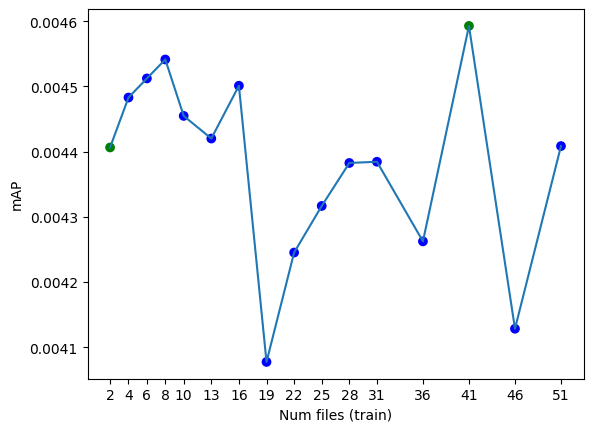

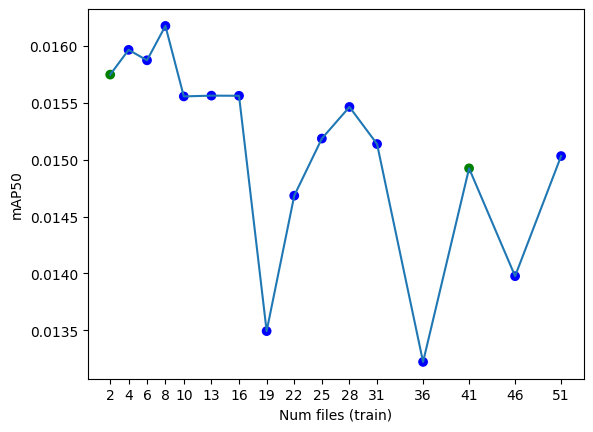

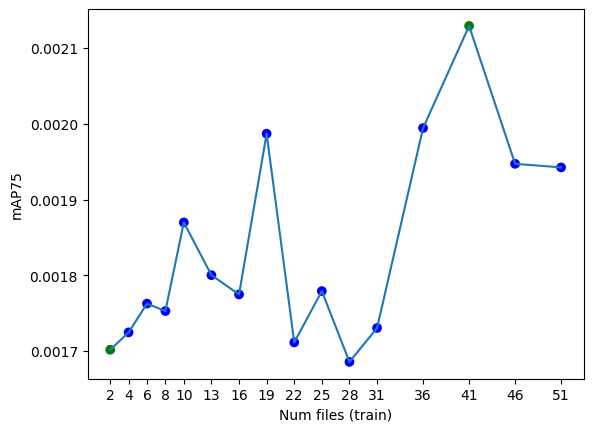

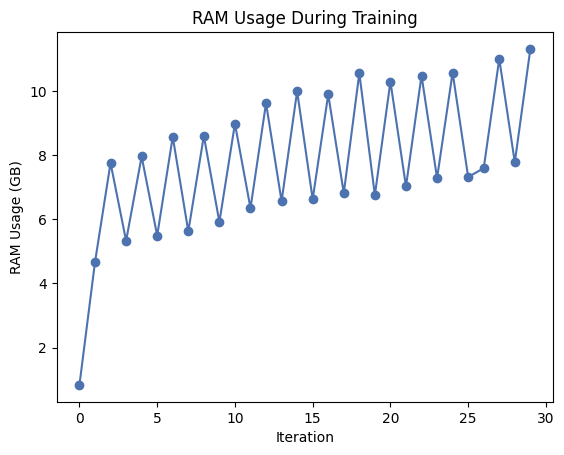

In [4]:
locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/puddle-segmentation-8/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5
FIB_FLAG = True
PREV_NUM = 15
THRESHOLD = 0.001

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
# exp_inc.train_test_val_split(KEEP_PERC)
# cls_tl_dict, cls_fif_dict = exp_inc.take_piece(PIECE_PERC, FIB_FLAG)
exp_inc.increm_learning(KEEP_PERC, ITERS, PIECE_PERC, FIB_FLAG, PREV_NUM, THRESHOLD)
exp_inc.plot_ram_usage()

### Сравнение базового и инкрементального обучения

locale.getpreferredencoding = lambda: "UTF-8"

PATH_TO_MODEL = "/kaggle/working/yolov8m-seg.pt"
PATH_TO_YAML = "/kaggle/working/feet-14/data.yaml"
TRAIN_PERC = 0.8
TEST_PERC = 0.1
VAL_PERC = 0.1
KEEP_PERC = 1.0
PIECE_PERC = 0.05
ITERS = 5

result_dict_base = dict()
result_dict_inc = dict()
color_dict_inc = dict()

exp_base = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC)
result_dict_base = exp_base.base_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_base.plot_ram_usage()
del(exp_base)

exp_inc = YoloModel(PATH_TO_MODEL, PATH_TO_YAML, TRAIN_PERC, TEST_PERC, VAL_PERC, 1, 1)
result_dict_inc, color_dict_inc = exp_inc.increm_learning(KEEP_PERC, PIECE_PERC, ITERS)
exp_inc.plot_ram_usage()

import math 

map_base_list = [j[0] for j in result_dict_base.values()]
map_inc_list = [j[0] for j in result_dict_inc.values()]
mse = 0
for map_base, map_inc in zip(map_base_list, map_inc_list):
    dev = (map_base - map_inc)
    mse += dev**2
print(f"MSE = {mse}\nRMSE = {math.sqrt(mse)}")

metrics_names = ("mAP","mAP50", "mAP75")
for i, metric in enumerate(metrics_names):
    plt.plot(list(result_dict_base.keys()),
             [j[i] for j in result_dict_base.values()],
             marker='o',
             color="green",
             linestyle='-',
             zorder=0,
             label = "Базовое обучение")
    
    plt.scatter(list(result_dict_inc.keys()),
                [j[i] for j in result_dict_inc.values()],
                color=list(color_dict_inc.values()),
                zorder=1)
    plt.plot(list(result_dict_inc.keys()),
             [j[i] for j in result_dict_inc.values()],
             linestyle='-',
             label = "Инкрементальное обучение")
    
    plt.ylabel(metric)
    plt.xlabel("Keep percent (%)")
    plt.legend()
    plt.show()

num_folders = 1 / PIECE_PERC
for folder in range(int(num_folders)):
    dir_path = f"temp_{folder+1}/train/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/train/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/labels"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]))
    dir_path = f"temp_{folder+1}/valid/images"
    print(dir_path, len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))]), '\n')
    
